<a href="https://colab.research.google.com/github/Pranesh1306/Pranesh1306/blob/main/qwe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    image = image / 255.0  # Normalize by dividing by 255
    return image

def preprocess_label(label_path, target_size):
    label = cv2.imread(label_path)
    label = cv2.resize(label, target_size, interpolation=cv2.INTER_NEAREST)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    label = label / 255.0  # Normalize by dividing by 255
    return label

def preprocess_data(image_folder, label_folder, target_size):
    images = []
    labels = []

    image_files = os.listdir(image_folder)
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, image_file)

        image = preprocess_image(image_path, target_size)
        label = preprocess_image(label_path, target_size)

        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [3]:
# Paths to the image and label folders
import zipfile
zip_file_path_1 = "images.zip"
zip_file_path_2 = "labels.zip"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path_1, 'r') as zip_ref:
    zip_ref.extractall('images')  # Extract to the 'images' directory
# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path_2, 'r') as zip_ref:
    zip_ref.extractall('labels')  # Extract to the 'images' directory    
    

In [4]:
image_folder = "/content/images"
label_folder = "/content/labels"

In [5]:
# Preprocess the data
target_size = (256, 256)
images, labels = preprocess_data(image_folder,label_folder, target_size)

In [6]:
np.shape(images)

(220, 256, 256, 3)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3
)
# Convert the tuples to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Reshape the images and labels to match the expected input shape
reshaped_images = images.reshape(-1, target_size[0], target_size[1], 3)
reshaped_labels = labels.reshape(-1, target_size[0], target_size[1], 3)

# Generate augmented images
augmented_images = []
augmented_labels = []
for image in reshaped_images:
    augmented_images.extend(datagen.flow(np.expand_dims(image, axis=0), batch_size=1)[0])
for label in reshaped_labels:
    augmented_labels.extend(datagen.flow(np.expand_dims(label, axis=0), batch_size=1)[0])

# Convert the augmented images back to numpy array format
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [8]:
# Combine original and augmented images for training
combined_images = np.concatenate((images, augmented_images), axis=0)
combined_labels = np.concatenate((labels, augmented_labels), axis=0)

# Convert the combined dataset back to separate arrays
combined_images = np.array(list(combined_images))
combined_labels = np.array(list(combined_labels))

train_images, test_images, train_labels, test_labels = train_test_split(combined_images,combined_labels, test_size=0.2, random_state=42)


<ipython-input-9-03f1e306198d>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


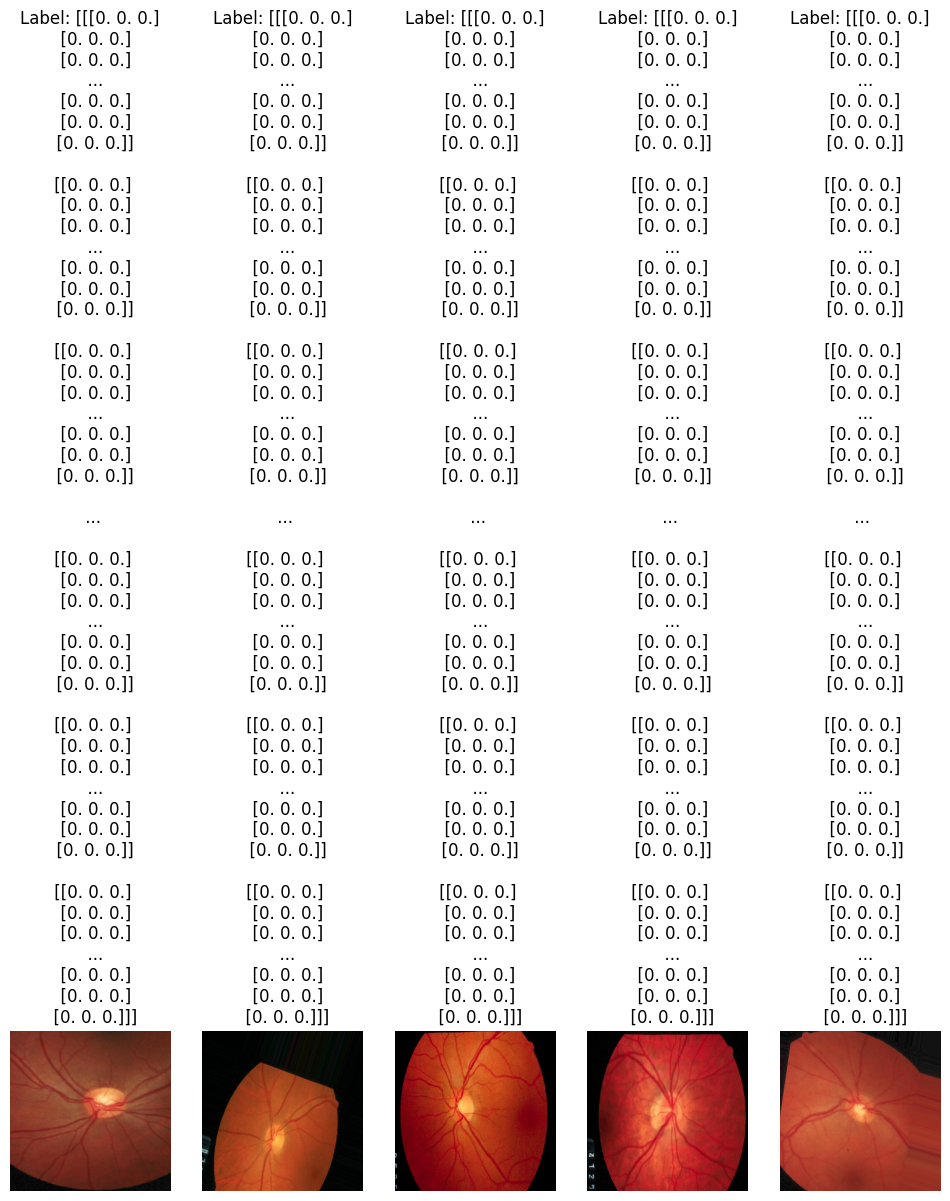

In [9]:
import matplotlib.pyplot as plt

# Display a few images with their labels
num_images = 5  # Number of images to display
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(12, 6))

for i in range(num_images):
    # Display the image
    axes[i].imshow(train_images[i])  # Assuming train_images contains the input images
    axes[i].axis('off')
    
    # Display the label
    axes[i].set_title(f"Label: {train_labels[i]}")  # Assuming train_labels contains the corresponding labels

plt.tight_layout()
plt.show()

In [10]:
np.shape(train_images)

(352, 256, 256, 3)

In [11]:
!pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [26]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, LearningRateScheduler

# Step 2: Load the pre-trained EfficientNetB0 model as the base model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Step 3: Freeze the layers of the base model
base_model.trainable = False

# Step 4: Build the attention U-Net on top of the base model
inputs = keras.Input(shape=(256, 256, 3))
x = base_model(inputs)
# Implement the attention module here (code not provided)
# Add your attention module layers to the model
outputs = keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(x)  # Change the number of channels to 3
model = keras.Model(inputs, outputs)

# Resize the logits to match the test image dimensions
test_logits = tf.image.resize(outputs, (256, 256), method=tf.image.ResizeMethod.BILINEAR)

# Step 5: Train the network weights on ImageNet using transfer learning
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assuming your train_labels have shape (batch_size, 256, 256, 3)
# Resize the labels to match the logits
train_labels_resized = tf.image.resize(train_labels, (8, 8), method=tf.image.ResizeMethod.BILINEAR)

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, monitor='accuracy', restore_best_weights=True)

# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr  # Keep the initial learning rate for the first 5 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Reduce the learning rate exponentially after 5 epochs

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

model.fit(train_images, train_labels_resized, batch_size=32, epochs=20, callbacks=[early_stopping, lr_scheduler_callback])

# Step 6: Fine-tune the weights of U-Net using a small labeled dataset
# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
# Select the layers to fine-tune
fine_tune_at = 100  # Example: Fine-tune from layer 100 onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
# Recompile the model to apply the changes
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fine-tune the model on the train_images and train_labels
model.fit(train_images, train_labels_resized, batch_size=32, epochs=10, callbacks=[early_stopping, lr_scheduler_callback])

# Step 7: Evaluate the performance of the model on the test datasets
# Assuming your test_labels have shape (batch_size, 256, 256, 3)
# Resize the test_labels to match the logits
test_labels_resized = tf.image.resize(test_labels, (8, 8), method=tf.image.ResizeMethod.BILINEAR)

loss, accuracy = model.evaluate(test_images, test_labels_resized)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


Epoch 1/20
11/11 [==============================] - 7s 111ms/step - loss: 0.5092 - accuracy: 0.0305 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 1s 79ms/step - loss: 0.2275 - accuracy: 0.0253 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 1s 84ms/step - loss: 0.1544 - accuracy: 0.0285 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 1s 97ms/step - loss: 0.1396 - accuracy: 0.1478 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 1s 81ms/step - loss: 0.1314 - accuracy: 0.1435 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 1s 81ms/step - loss: 0.1288 - accuracy: 0.1142 - lr: 9.0484e-04
Epoch 7/20
11/11 [==============================] - 1s 81ms/step - loss: 0.1272 - accuracy: 0.1196 - lr: 8.1873e-04
Epoch 8/20
11/11 [==============================] - 1s 80ms/step - loss: 0.1283 - accuracy: 0.1440 - lr: 7.4082e-04
Epoch 9/20
11/11 [==============================] - 1s 90ms/step - loss: 0.1251 - accuracy:

3/3 [==============================] - 2s 93ms/step - loss: 0.2188 - accuracy: 0.9047
Test Loss: 0.21879595518112183
Test Accuracy: 0.9046519994735718


In [30]:
import tensorflow as tf
import numpy as np

# Assuming your test_labels have shape (batch_size, 256, 256, 3)
# Assuming your test_logits have shape (batch_size, 8, 8, 3)

# Resize the predicted logits to match the test labels
test_predictions_resized = tf.image.resize(test_logits, (256, 256), method=tf.image.ResizeMethod.BILINEAR)



# Flatten the labels and predictions for easier computation
test_labels_flat = test_labels.reshape(-1)
test_predictions_flat = test_predictions.reshape(-1)

# Calculate True Positives, False Positives, False Negatives
TP = np.sum((test_labels_flat == 1) & (test_predictions_flat == 1))
FP = np.sum((test_labels_flat == 0) & (test_predictions_flat == 1))
FN = np.sum((test_labels_flat == 1) & (test_predictions_flat == 0))

# Calculate Intersection over Union (IOU)
iou = TP / (TP + FP + FN)

# Calculate Sensitivity (True Positive Rate, Recall)
sensitivity = TP / (TP + FN)

# Calculate Specificity (True Negative Rate)
specificity = np.sum((test_labels_flat == 0) & (test_predictions_flat == 0)) / np.sum(test_labels_flat == 0)

print('IOU:', iou)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)


AttributeError: ignored

In [37]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Assuming your test_labels have shape (batch_size, 256, 256, 3)
# Resize the test_labels to match the logits
test_labels_resized = tf.image.resize(test_labels, (256, 256), method=tf.image.ResizeMethod.BILINEAR)
test_labels_resized = np.dot(test_labels_resized[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale

# Make predictions
predictions = model.predict(test_images)
predictions_resized = tf.image.resize(predictions, (256, 256), method=tf.image.ResizeMethod.BILINEAR)
predictions_resized = np.dot(predictions_resized[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale

# Calculate metrics
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_specificity(y_true, y_pred):
    true_negative = np.sum((1 - y_true) * (1 - y_pred))
    true_negative_rate = true_negative / np.sum(1 - y_true)
    return true_negative_rate

def calculate_sensitivity(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    true_positive_rate = true_positive / np.sum(y_true)
    return true_positive_rate

iou = calculate_iou(test_labels_resized, predictions_resized)
specificity = calculate_specificity(test_labels_resized, predictions_resized)
sensitivity = calculate_sensitivity(test_labels_resized, predictions_resized)

print("IOU:", iou)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)


3/3 [==============================] - 0s 91ms/step
IOU: 0.033151799982244316
Specificity: 0.8452774588992996
Sensitivity: 0.2243239118472787


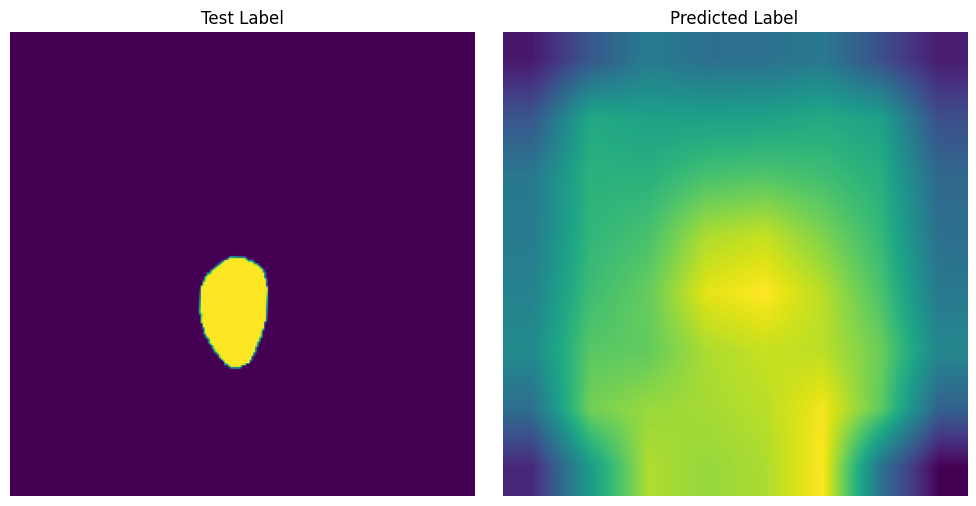

In [38]:
import matplotlib.pyplot as plt

# Assuming test_labels and predicted_labels are NumPy arrays containing two images

# Adjust the figure size
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the test label
axes[0].imshow(test_labels_resized[0])
axes[0].set_title("Test Label")
axes[0].axis('off')

# Display the predicted label
axes[1].imshow(predictions_resized[0])
axes[1].set_title("Predicted Label")
axes[1].axis('off')

plt.tight_layout()
plt.show()